# BAX Emittance Minimization (LCLS-II)
In this notebook, we hope to demonstrate Bayesian Algorithm Execution (BAX) in Xopt as a means of minimizing the emittance at LCLS-II. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

In [1]:
# set up env for running on SLAC production servers
import os
os.environ['OMP_NUM_THREADS']=str(6)

In [2]:
run_dir = '/home/physics/ml_tuning/20240225_LCLS_II_Injector'

# Read pv info from YAML files

In [3]:
import sys
import yaml
sys.path.append("../../")
sys.path.append("../../../")

from common import get_pv_objects, save_reference_point, set_magnet_strengths, \
    measure_pvs

In [4]:
pv_bounds = yaml.safe_load(open("../../pv_bounds.yml"))
pv_objects = get_pv_objects("../../tracked_pvs.yml")

In [5]:
pv_bounds

{'QUAD:GUNB:212:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:212:2:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:1:BCTRL': [-0.005, 0.005],
 'QUAD:GUNB:823:2:BCTRL': [-0.005, 0.005],
 'QUAD:HTR:120:BCTRL': [-4.48, 1],
 'QUAD:HTR:140:BCTRL': [-4.4778, 4.4762],
 'QUAD:HTR:300:BCTRL': [-4.46035, 4.4692],
 'QUAD:HTR:320:BCTRL': [-4.46919, 4.4792],
 'SOLN:GUNB:212:BCTRL': [0.044, 0.044574],
 'SOLN:GUNB:823:BCTRL': [0.021, 0.0255]}

# load reference point
Also define a function to write the reference values to the pvs

In [37]:
reference = yaml.safe_load(open("../../reference.yml"))

def reset_pvs():
    set_magnet_strengths(reference, pv_objects, validate=False)

In [38]:
reset_pvs()

QUAD:GUNB:212:1:BCTRL 0.0019979999999999998
QUAD:GUNB:212:2:BCTRL 0.0024625
QUAD:GUNB:823:1:BCTRL 0.0029849192
QUAD:GUNB:823:2:BCTRL 0.0020575000000000003
QUAD:HTR:120:BCTRL -2.335956937533228
QUAD:HTR:140:BCTRL 1.6975759721701786
QUAD:HTR:300:BCTRL 1.717953462815712
QUAD:HTR:320:BCTRL -1.7056625208016953
SOLN:GUNB:212:BCTRL 0.044250000000000005
SOLN:GUNB:823:BCTRL 0.024170000000000014


In [8]:
from scripts.image import ImageDiagnostic
import yaml

fname = 'otr_diagnostic.yml' #run_dir + "OTRS_HTR_330_config.yml"

image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))

image_diagnostic.min_log_intensity = 3.0
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
print(image_diagnostic.yaml())


screen_name: OTRS:HTR:330
array_data_suffix: Image:ArrayData
array_n_cols_suffix: Image:ArraySize0_RBV
array_n_rows_suffix: Image:ArraySize1_RBV
resolution_suffix: RESOLUTION
resolution: 19.24
beam_shutter_pv: TPR:LGUN:TS01:0:TRG00_SYS2_TCTL
extra_pvs: []
background_file: null
save_image_location: /home/physics/ml_tuning/20240225_LCLS_II_Injector
roi: null
min_log_intensity: 3.0
bounding_box_half_width: 3.0
wait_time: 1.0
n_fitting_restarts: 2
visualize: false
return_statistics: false
threshold: 0.0
testing: false



In [9]:
image_diagnostic.measure_background()

array([[0. , 0.2, 0. , ..., 0. , 0. , 0. ],
       [0. , 0.2, 0.2, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.2, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.2, ..., 0. , 0. , 0.2],
       [0. , 0. , 0.2, ..., 0. , 0. , 0. ]])

In [10]:
import matplotlib.pyplot as plt

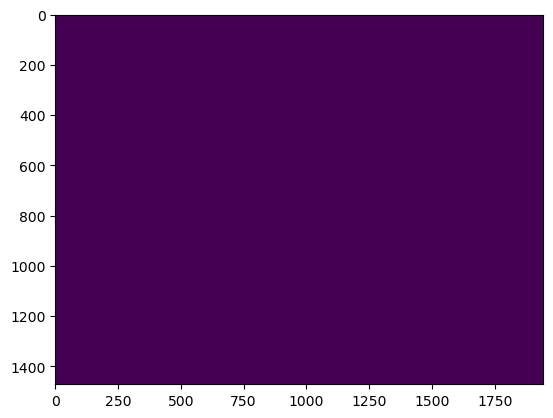

In [11]:
plt.imshow(image_diagnostic.background_image)

In [12]:
image_diagnostic.resolution

19.24

In [14]:
from epics import caget

In [16]:
caget('OTRS:HTR:330:RESOLUTION')

19.24

fitting image


{'Cx': 1058.4439537308397,
 'Cy': 953.1602144331546,
 'Sx': 244.24046158298157,
 'Sy': 317.5757721755835,
 'bb_penalty': -369.0495324709556,
 'total_intensity': 735496.6000000003,
 'log10_total_intensity': 5.866580669443357}

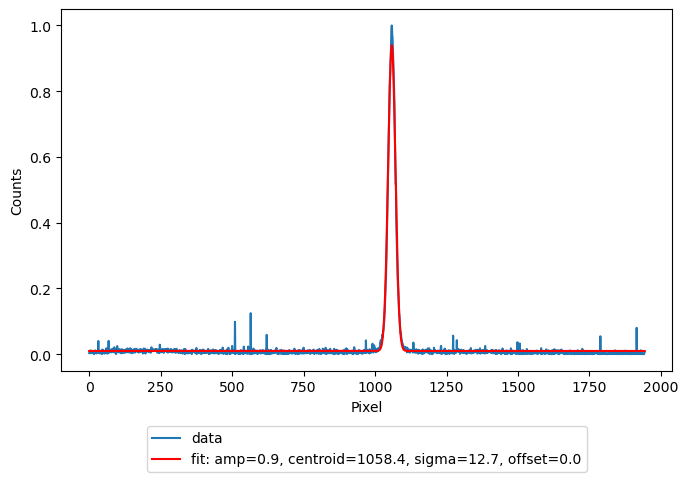

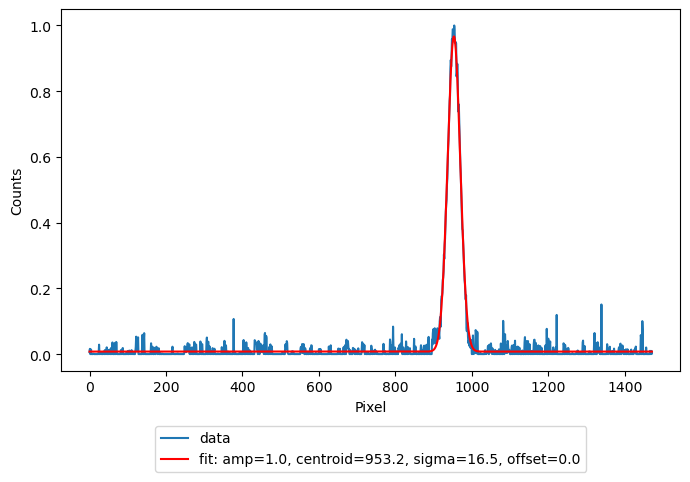

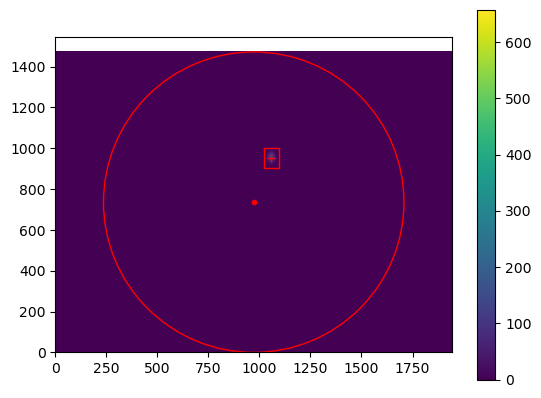

In [13]:
image_diagnostic.test_measurement()

# Imports

In [9]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator


import time
import numpy as np
import random

# General settings

In [10]:
# general settings
N_OBS_INIT = 3 # number of random initial observations
N_ITER = 20 # number of iterations for Xopt to perform

# BAX algorithm settings
N_SAMPLES = 10
N_STEPS_MEASUREMENT_PARAM = 3

# measurement settings
VAR_FILE = '../variables.csv'
TUNING_VARIABLES = ["SOLN:GUNB:212:BCTRL", 'QUAD:HTR:120:BCTRL']
SCAN_VARIABLE = "QUAD:HTR:120:BCTRL" # assign measurement parameter
SCREEN_NAME = "OTRS:HTR:330"
X_KEY = "xrms_sq"
Y_KEY = "yrms_sq"
QUAD_LENGTH = 0.124 # m
RMAT_X =  [[-1.4591, 2.9814],
[-0.4998, 0.3358]] # m
RMAT_Y = [[4.8650, 8.5737],
[-0.1597, -0.0758]]
THICK_QUAD = False
BEAM_ENERGY = 0.088 # GeV
SCALE_FACTOR = 2.74 # multiplicative factor to convert from measurement quad PV units to geometric focusing strength
ROI = None
THRESHOLD = 0

# random seeds for reproducibility
rand_seed = 2
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) # only(?) affects initial random observations through Xopt 
random.seed(rand_seed)

# Evaluator

In [11]:
import time
# define function to measure the total size on OTR4
def eval_beamsize(inputs):
    
    # set pvs and wait for BACT to settle to correct values (validate=True)
    set_magnet_strengths(inputs, pv_objects, validate=False)
    time.sleep(2)
    # measure all pvs - except for names in inputs
    results = measure_pvs(
        [name for name in pv_objects.keys() if name not in inputs], pv_objects 
    )

    # do some calculations
    results["time"] = time.time()

    # add beam size measurement to results dict
    beamsize_results = image_diagnostic.measure_beamsize()
    results["Sx_mm"] = beamsize_results["Sx"] * 1e-2
    results["Sy_mm"] = beamsize_results["Sy"] * 1e-2

    #add beam size squared (mm^2)
    results["xrms_sq"] = results["Sx_mm"]**2
    results["yrms_sq"] = results["Sy_mm"]**2
    results = beamsize_results | results
    return results

In [12]:
eval_beamsize({})

fitting image


{'Cx': 1058.1013079326483,
 'Cy': 958.6027830404379,
 'Sx': 230.44662347773033,
 'Sy': 309.2915859467549,
 'bb_penalty': -372.70175194781416,
 'total_intensity': 627147.0,
 'log10_total_intensity': 5.797369349134101,
 'save_filename': '/home/physics/ml_tuning/20240225_LCLS_II_Injector/OTRS_HTR_330_1708933529.h5',
 'QUAD:HTR:140:BCTRL': 1.6975759721701786,
 'QUAD:HTR:300:BCTRL': 1.717953462815712,
 'QUAD:HTR:320:BCTRL': -1.7056625208016953,
 'SOLN:GUNB:212:BCTRL': 0.044250000000000005,
 'QUAD:GUNB:212:1:BCTRL': 0.0019979999999999998,
 'QUAD:GUNB:212:2:BCTRL': 0.0024625,
 'SOLN:GUNB:823:BCTRL': 0.024170000000000014,
 'QUAD:GUNB:823:1:BCTRL': 0.0029849192,
 'QUAD:GUNB:823:2:BCTRL': 0.0020575000000000003,
 'ACCL:GUNB:455:PDES': -132.5,
 'ACCL:L0B:0110:ADES': 6.5,
 'ACCL:L0B:0110:PDES': -20.0,
 'ACCL:L0B:0130:PDES': 0.0,
 'QUAD:HTR:120:BCTRL': -2.335956937533228,
 'time': 1708933529.756722,
 'Sx_mm': 2.3044662347773035,
 'Sy_mm': 3.0929158594675488,
 'xrms_sq': 5.310564627228682,
 'yrms_sq'

## Constants and Constraints

In [13]:
# constants



# constraints
image_constraints = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", 4]
}

# VOCS

In [14]:
# construct vocs
vocs = VOCS(
    variables = {ele: pv_bounds[ele] for ele in TUNING_VARIABLES},
    constraints = image_constraints,
    observables = [X_KEY, Y_KEY]
)

# get dimension index for measurement device
MEAS_DIM = list(vocs.variable_names).index(SCAN_VARIABLE)
print('MEAS_DIM =', MEAS_DIM)

MEAS_DIM = 0


In [15]:
vocs.variable_names

['QUAD:HTR:120:BCTRL', 'SOLN:GUNB:212:BCTRL']

# BAX algorithm

In [16]:
import copy
from abc import ABC, abstractmethod
from typing import List, Dict, Optional, Tuple, Union

import torch
from pydantic import Field

from scipy.optimize import minimize
from torch import Tensor
from xopt.generators.bayesian.bax.algorithms import Algorithm

from emitopt.sampling import (
    draw_linear_product_kernel_post_paths,
    draw_product_kernel_post_paths,
)
from botorch.models.model import Model, ModelList
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths
from gpytorch.kernels import ProductKernel, MaternKernel

from emitopt.analysis import compute_emit_bmag


def unif_random_sample_domain(n_samples, domain):
    ndim = len(domain)

    # uniform sample, rescaled, and shifted to cover the domain
    x_samples = torch.rand(n_samples, ndim) * torch.tensor(
        [bounds[1] - bounds[0] for bounds in domain]
    ) + torch.tensor([bounds[0] for bounds in domain])

    return x_samples


class ScipyMinimizeEmittanceXY(Algorithm, ABC):
    name = "ScipyMinimizeEmittance"
    x_key: str = Field(None,
        description="key designating the beamsize squared output in x from evaluate function")
    y_key: str = Field(None,
        description="key designating the beamsize squared output in y from evaluate function")
    scale_factor: float = Field(1.0,
        description="factor by which to multiply the quad inputs to get focusing strengths")
    q_len: float = Field(
        description="the longitudinal thickness of the measurement quadrupole"
    )
    rmat_x: Tensor = Field(None,
        description="tensor shape 2x2 containing downstream rmat for x dimension"
    )
    rmat_y: Tensor = Field(None,
        description="tensor shape 2x2 containing downstream rmat for y dimension"
    )
    meas_dim: int = Field(
        description="index identifying the measurement quad dimension in the model"
    )
    n_steps_measurement_param: int = Field(
        11, description="number of steps to use in the virtual measurement scans"
    )
    scipy_options: dict = Field(
        None, description="options to pass to scipy minimize")
    thick_quad: bool = Field(True,
        description="Whether to use thick-quad (or thin, if False) transport for emittance calc")

    @property
    def observable_names_ordered(self) -> list:  
        # get observable model names in the order they appear in the model (ModelList)
        return [key for key in [self.x_key, self.y_key] if key]

    def get_execution_paths(self, model: ModelList, bounds: Tensor, tkwargs=None, init='smallest', verbose=False):
        if not (self.x_key or self.y_key):
            raise ValueError("must provide a key for x, y, or both.")
        if (self.x_key and self.rmat_x is None) or (self.y_key and self.rmat_y is None):
            raise ValueError("must provide rmat for each transverse dimension (x/y) being modeled.")
    
        tkwargs = tkwargs if tkwargs else {"dtype": torch.double, "device": "cpu"}
        cpu_tkwargs = {"dtype": torch.double, "device": "cpu"}

        cpu_models = [copy.deepcopy(m).cpu() for m in model.models]

        sample_funcs_list = []
        for cpu_model in cpu_models:
            if type(cpu_model.covar_module.base_kernel) == ProductKernel:
                sample_funcs = draw_product_kernel_post_paths(cpu_model, n_samples=self.n_samples)
            if type(cpu_model.covar_module.base_kernel) == MaternKernel:
                sample_funcs = draw_matheron_paths(cpu_model, sample_shape=torch.Size([self.n_samples]))
            sample_funcs_list += [sample_funcs]

        temp_id = self.meas_dim + 1
        tuning_domain = torch.cat((bounds.T[: self.meas_dim], bounds.T[temp_id:]))
        if init=='random':
            xs_tuning_init = unif_random_sample_domain(
                self.n_samples, tuning_domain
            ).double()
            x_tuning_init = xs_tuning_init.flatten()
        if init=='smallest':
            if len(self.observable_names_ordered) == 1:
                bss = model.models[0].outcome_transform.untransform(model.models[0].train_targets)[0]
            if len(self.observable_names_ordered) == 2:
                bss_x, bss_y = [m.outcome_transform.untransform(m.train_targets)[0]
                                for m in model.models]
                bss = torch.sqrt(bss_x * bss_y)

            x_smallest_observed_beamsize = model.models[0]._original_train_inputs[torch.argmin(bss)].reshape(1,-1)

            tuning_dims = list(range(bounds.shape[1]))
            tuning_dims.remove(self.meas_dim)
            tuning_dims = torch.tensor(tuning_dims)
            x_tuning_best = torch.index_select(x_smallest_observed_beamsize, dim=1, index=tuning_dims)
            x_tuning_init = x_tuning_best.repeat(self.n_samples,1).flatten()
    #         print(x_tuning_init)

        # minimize
        def target_func_for_scipy(x_tuning_flat):
            return (
                self.sum_samplewise_emittance_target(
                    sample_funcs_list,
                    torch.tensor(x_tuning_flat, **cpu_tkwargs),
                    bounds,
                    cpu_tkwargs
                )
                .detach()
                .numpy()
            )

        def target_func_for_torch(x_tuning_flat):
            return self.sum_samplewise_emittance_target(
                    sample_funcs_list,
                    x_tuning_flat,
                    bounds,
                    cpu_tkwargs
                )
#         torch_target = target_func_for_torch(torch.zeros(self.n_samples))
#         scipy_target = target_func_for_scipy(torch.zeros(self.n_samples))
#         print('torch_target=',torch_target)
#         print('scipy_target=',scipy_target)
        def target_jac_for_scipy(x):
#             val = torch.autograd.functional.jacobian(
#                     target_func_for_torch, torch.tensor(x, **cpu_tkwargs)
#                 )
#             print('jac = ', val)
#             print('x = ', x)
            return (
                torch.autograd.functional.jacobian(
                    target_func_for_torch, torch.tensor(x, **cpu_tkwargs)
                )
                .detach()
                .numpy()
            )

        
        # get bounds for sample emittance minimization (tuning domain)
        bounds_for_scipy = tuning_domain.repeat(self.n_samples, 1).detach().cpu().numpy()
        
        # perform sample emittance minimization
        res = minimize(
            target_func_for_scipy,
            x_tuning_init.detach().cpu().numpy(),
            jac=target_jac_for_scipy,
            bounds=bounds_for_scipy,
            options=self.scipy_options,
        )

        if verbose:
            print(
                "ScipyMinimizeEmittance evaluated",
                self.n_samples,
                "(pathwise) posterior samples",
                res.nfev,
                "times in get_sample_optimal_tuning_configs().",
            )

            print(
                "ScipyMinimizeEmittance evaluated",
                self.n_samples,
                "(pathwise) posterior sample jacobians",
                res.njev,
                "times in get_sample_optimal_tuning_configs().",
            )

            print(
                "ScipyMinimizeEmittance took",
                res.nit,
                "steps in get_sample_optimal_tuning_configs().",
            )

        x_tuning_best_flat = torch.tensor(res.x, **cpu_tkwargs)
        x_tuning_best = x_tuning_best_flat.reshape(
            self.n_samples, 1, -1
        )  # each row represents its respective sample's optimal tuning config

        emit_best, is_valid = self.evaluate_posterior_emittance_samples(sample_funcs_list, 
                                                                 x_tuning_best, 
                                                                 bounds, 
                                                                 tkwargs=cpu_tkwargs,
                                                                 transform_target=False)[:2]
        
        xs_exe = self.get_meas_scan_inputs(x_tuning_best, bounds, cpu_tkwargs)

        # evaluate posterior samples at input locations
        ys_exe_list = [sample_funcs(xs_exe).reshape(
            self.n_samples, self.n_steps_measurement_param, 1
        ) for sample_funcs in sample_funcs_list]
        ys_exe = torch.cat(ys_exe_list, dim=-1)

        if sum(is_valid) < 3:
            if verbose:
                print("Scipy failed to find at least 3 physically valid solutions.")
            # no cut
            cut_ids = torch.tensor(range(self.n_samples), device="cpu")
        else:
            # only keep the physically valid solutions
            cut_ids = torch.tensor(range(self.n_samples), device="cpu")[is_valid.flatten()]

        xs_exe = torch.index_select(xs_exe, dim=0, index=cut_ids)
        ys_exe = torch.index_select(ys_exe, dim=0, index=cut_ids)
        x_tuning_best_retained = torch.index_select(x_tuning_best, dim=0, index=cut_ids)
        emit_best_retained = torch.index_select(emit_best, dim=0, index=cut_ids)

        results_dict = {
            "xs_exe": xs_exe.to(**tkwargs),
            "ys_exe": ys_exe.to(**tkwargs),
            "x_tuning_best_retained": x_tuning_best_retained.to(**tkwargs),
            "emit_best_retained": emit_best_retained.to(**tkwargs),
            "x_tuning_best": x_tuning_best.to(**tkwargs),
            "emit_best": emit_best.to(**tkwargs),
            "is_valid": is_valid.to(device=tkwargs['device']),
            "sample_funcs_list": sample_funcs_list
        }

        return xs_exe.to(**tkwargs), ys_exe.to(**tkwargs), results_dict

    def get_meas_scan_inputs(self, x_tuning: Tensor, bounds: Tensor, tkwargs: dict=None):
        """
        A function that generates the inputs for virtual emittance measurement scans at the tuning
        configurations specified by x_tuning.

        Parameters:
            x_tuning: a tensor of shape n_points x n_tuning_dims, where each row specifies a tuning
                        configuration where we want to do an emittance scan.
                        >>batchshape x n_tuning_configs x n_tuning_dims (ex: batchshape = n_samples x n_tuning_configs)
        Returns:
            xs: tensor, shape (n_tuning_configs*n_steps_meas_scan) x d,
                where n_tuning_configs = x_tuning.shape[0],
                n_steps_meas_scan = len(x_meas),
                and d = x_tuning.shape[1] -- the number of tuning parameters
                >>batchshape x n_tuning_configs*n_steps x ndim
        """
        # each row of x_tuning defines a location in the tuning parameter space
        # along which to perform a quad scan and evaluate emit

        # expand the x tensor to represent quad measurement scans
        # at the locations in tuning parameter space specified by X
        tkwargs = tkwargs if tkwargs else {"dtype": torch.double, "device": "cpu"}

        x_meas = torch.linspace(
            *bounds.T[self.meas_dim], self.n_steps_measurement_param, **tkwargs
        )
        
        # prepare column of measurement scans coordinates
        x_meas_expanded = x_meas.reshape(-1,1).repeat(*x_tuning.shape[:-1],1)
        
        # repeat tuning configs as necessary and concat with column from the line above
        # to make xs shape: (n_tuning_configs*n_steps_quad_scan) x d ,
        # where d is the full dimension of the model/posterior space (tuning & meas)
        x_tuning_expanded = torch.repeat_interleave(x_tuning, 
                                                    self.n_steps_measurement_param, 
                                                    dim=-2)


        x = torch.cat(
            (x_tuning_expanded[..., :self.meas_dim], x_meas_expanded, x_tuning_expanded[..., self.meas_dim:]), 
            dim=-1
        )

        return x
            
    def sum_samplewise_emittance_target(self, sample_funcs_list, x_tuning_flat, bounds, tkwargs):
        assert len(x_tuning_flat.shape) == 1 and len(x_tuning_flat) == self.n_samples * (bounds.shape[1]-1)
        
        x_tuning = x_tuning_flat.double().reshape(self.n_samples, 1, -1)

        sample_emittance = self.evaluate_posterior_emittance_samples(sample_funcs_list, 
                                                                 x_tuning, 
                                                                 bounds, 
                                                                 tkwargs,
                                                                 transform_target=True)[0]

        sample_targets_sum = torch.sum(sample_emittance)

        return sample_targets_sum

    def evaluate_posterior_emittance_samples(self, model, x_tuning, bounds, tkwargs:dict=None, n_samples=10000, transform_target=False):
        # x_tuning must be shape n_tuning_configs x n_tuning_dims
        tkwargs = tkwargs if tkwargs else {"dtype": torch.double, "device": "cpu"}
        x = self.get_meas_scan_inputs(x_tuning, bounds, tkwargs) # result shape n_tuning_configs*n_steps x ndim
        
        if isinstance(model, ModelList):
            assert len(x_tuning.shape)==2
            p = model.posterior(x) 
            bss = p.sample(torch.Size([n_samples])) # result shape n_samples x n_tuning_configs*n_steps x num_outputs (1 or 2)

            x = x.reshape(x_tuning.shape[0], self.n_steps_measurement_param, -1) # result n_tuning_configs x n_steps x ndim
            x = x.repeat(n_samples,1,1,1) 
            # result shape n_samples x n_tuning_configs x n_steps x ndim
            bss = bss.reshape(n_samples, x_tuning.shape[0], self.n_steps_measurement_param, -1)
            # result shape n_samples x n_tuning_configs x n_steps x num_outputs (1 or 2)
        else:
            assert x_tuning.shape[0]==self.n_samples
            beamsize_squared_list = [sample_funcs(x).reshape(*x_tuning.shape[:-1], self.n_steps_measurement_param)
                                     for sample_funcs in model]
            # each tensor in beamsize_squared (list) will be shape n_samples x n_tuning_configs x n_steps

            x = x.reshape(*x_tuning.shape[:-1], self.n_steps_measurement_param, -1)
            # n_samples x n_tuning_configs x n_steps x ndim
            bss = torch.stack(beamsize_squared_list, dim=-1) 
            # result shape n_samples x n_tuning_configs x n_steps x num_outputs (1 or 2)
            
        if self.x_key and not self.y_key:
            k = x[..., self.meas_dim] * self.scale_factor # n_samples x n_tuning x n_steps
            beamsize_squared = bss[...,0] # result shape n_samples x n_tuning x n_steps
            rmat = self.rmat_x.to(**tkwargs).repeat(*bss.shape[:2],1,1) # n_samples x n_tuning x 2 x 2
        if self.y_key and not self.x_key:
            k = x[..., self.meas_dim] * (-1. * self.scale_factor) # n_samples x n_tuning x n_steps
            beamsize_squared = bss[...,0] # result shape n_samples x n_tuning x n_steps
            rmat = self.rmat_y.to(**tkwargs).repeat(*bss.shape[:2],1,1) # n_samples x n_tuning x 2 x 2
        else:
            k_x = (x[..., self.meas_dim] * self.scale_factor) # n_samples x n_tuning x n_steps
            k_y = k_x * -1. # n_samples x n_tuning x n_steps
            k = torch.cat((k_x, k_y)) # shape (2*n_samples x n_tuning x n_steps)
            
            beamsize_squared = torch.cat((bss[...,0], bss[...,1])) 
            # shape (2*n_samples x n_tuning x n_steps)

            rmat_x = self.rmat_x.to(**tkwargs).repeat(*bss.shape[:2],1,1)
            rmat_y = self.rmat_y.to(**tkwargs).repeat(*bss.shape[:2],1,1)
            rmat = torch.cat((rmat_x, rmat_y)) # shape (2*n_samples x n_tuning x 2 x 2)

        emit, bmag, sig, is_valid = compute_emit_bmag(k, 
                                          beamsize_squared, 
                                          self.q_len, 
                                          rmat,  
                                          thick=self.thick_quad)
        # result shapes: (n_samples x n_tuning), (n_samples x n_tuning), (n_samples x n_tuning x 3 x 1), (n_samples x n_tuning) 
        # or (2*n_samples x n_tuning), (2*n_samples x n_tuning), (2*n_samples x n_tuning x 3 x 1), (2*n_samples x n_tuning) 

        if transform_target:
            emit_squared = sig[...,0,0]*sig[...,2,0] - sig[...,1,0]**2 
            # result shape (n_samples x n_tuning) or (2*n_samples x n_tuning)
            if self.x_key and self.y_key:
                res = (emit_squared[:bss.shape[0]].pow(2) * 
                       emit_squared[bss.shape[0]:].pow(2)).sqrt()
                is_valid = torch.logical_and(is_valid[:bss.shape[0]], is_valid[bss.shape[0]:])
            else:
                res = emit_squared.pow(2)
        else:
            if self.x_key and self.y_key:
                res = (emit[:bss.shape[0]] * emit[bss.shape[0]:]).sqrt()
                is_valid = torch.logical_and(is_valid[:bss.shape[0]], is_valid[bss.shape[0]:])
            else:
                res = emit
            #final shapes: n_samples x n_tuning_configs
        
        validity_rate = torch.sum(is_valid, dim=0)/is_valid.shape[0]
        #shape n_tuning_configs
        
        return res, is_valid, validity_rate

In [17]:
# from emitopt.algorithms import ScipyMinimizeEmittanceXY
algo_kwargs = {
        'x_key': X_KEY,
        'y_key': Y_KEY,
        'scale_factor': SCALE_FACTOR,
        'q_len': QUAD_LENGTH,
        'rmat_x': torch.tensor(RMAT_X),
        'rmat_y': torch.tensor(RMAT_Y),
        'n_samples': N_SAMPLES,
        'meas_dim': MEAS_DIM,
        'n_steps_measurement_param': N_STEPS_MEASUREMENT_PARAM,
        'thick_quad': THICK_QUAD
        }
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

# Product kernel model constructor

In [18]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(MEAS_DIM)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[MEAS_DIM])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[MEAS_DIM])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

# model_constructor = StandardModelConstructor(use_low_noise_prior=False)
model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=False)


# Numerical optimizer (for acquisition function)

In [19]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(n_restarts=20,
                                    max_iter=100)

# Initialize Xopt Optimizer

In [20]:
#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo)
#construct evaluator
evaluator = Evaluator(function=eval_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [21]:
optimizer.dump_file = 'BAX_run12.yml'

In [35]:
from epics import caget, caput

In [36]:
caget('QUAD:HTR:120:BCTRL')

-2.335956937533228

In [46]:
caput('QUAD:HTR:120:BCTRL', -2.335956937533228)

1

In [47]:
caget('SOLN:GUNB:212:BCTRL')

0.044250000000000005

In [51]:
caput('SOLN:GUNB:212:BCTRL', 0.044250000000000005)

1

In [22]:
results = {}

In [23]:
from epics import caget_many
from xopt.utils import get_local_region
# get current point
current_value = dict(zip(optimizer.vocs.variable_names, caget_many(optimizer.vocs.variable_names)))
# get small region around current point to sample
random_sample_region = get_local_region(current_value,optimizer.vocs, fraction=1)
# random sample in a local region
optimizer.random_evaluate(10, custom_bounds=random_sample_region)

QUAD:HTR:120:BCTRL -1.3892520637381809
SOLN:GUNB:212:BCTRL 0.04421746917999042
fitting image
QUAD:HTR:120:BCTRL 0.8579242495831555
SOLN:GUNB:212:BCTRL 0.04427027243788498
fitting image
QUAD:HTR:120:BCTRL -2.0121503787753263
SOLN:GUNB:212:BCTRL 0.04449675111137201
fitting image
QUAD:HTR:120:BCTRL -1.3855667115481576
SOLN:GUNB:212:BCTRL 0.044279206158393467
fitting image
QUAD:HTR:120:BCTRL -1.30361555543944
SOLN:GUNB:212:BCTRL 0.044468131517118675
fitting image
QUAD:HTR:120:BCTRL -0.8102348191012303
SOLN:GUNB:212:BCTRL 0.04412321762515323
fitting image
QUAD:HTR:120:BCTRL -0.12147451452737701
SOLN:GUNB:212:BCTRL 0.044083818182024934
fitting image
QUAD:HTR:120:BCTRL -2.393604895601637
SOLN:GUNB:212:BCTRL 0.04429030805534277
fitting image
QUAD:HTR:120:BCTRL -0.6421076117363869
SOLN:GUNB:212:BCTRL 0.044088073707404814
fitting image
QUAD:HTR:120:BCTRL -0.4622134675637093
SOLN:GUNB:212:BCTRL 0.04452828349619681
fitting image


,QUAD:HTR:120:BCTRL,SOLN:GUNB:212:BCTRL,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,...,ACCL:L0B:0110:ADES,ACCL:L0B:0110:PDES,ACCL:L0B:0130:PDES,time,Sx_mm,Sy_mm,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-1.389252,0.044217,1082.865180,849.116000,181.064789,791.919803,-287.230973,624032.0,5.795207,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,1.810648,7.919198,3.278446,62.713697,3.440611,False
1,0.857924,0.044270,NaN,NaN,NaN,NaN,28.098407,663706.0,5.821976,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,NaN,NaN,NaN,NaN,3.472235,False
2,-2.012150,0.044497,1106.828575,712.249808,246.535168,1180.440675,-132.286946,624087.0,5.795245,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,2.465352,11.804407,6.077959,139.344019,3.436222,False
3,-1.385567,0.044279,1084.380294,833.014530,201.038463,791.133218,-274.462728,612932.0,5.787412,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,2.010385,7.911332,4.041646,62.589177,3.457201,False
4,-1.303616,0.044468,1086.690735,824.689399,205.429966,858.517756,-261.093791,608026.0,5.783922,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,2.054300,8.585178,4.220147,73.705274,3.404721,False
5,-0.810235,0.044123,1096.465880,748.878448,410.279769,1001.956536,-166.740759,634225.0,5.802243,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,4.102798,10.019565,16.832949,100.391690,3.495205,False
6,-0.121475,0.044084,1122.282085,713.673838,252.667783,1625.398243,-70.336422,663014.0,5.821523,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,2.526678,16.253982,6.384101,264.191945,3.406030,False
7,-2.393605,0.044290,1074.049348,863.517713,181.143612,598.004736,-317.831464,620591.0,5.792805,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,1.811436,5.980047,3.281301,35.760966,3.514709,False
8,-0.642108,0.044088,1094.791872,783.698412,201.937337,1005.034964,-215.086531,616066.0,5.789627,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,2.019373,10.050350,4.077869,101.009528,3.491656,False
9,-0.462213,0.044528,1112.651077,712.332660,242.879018,1087.920234,-139.235169,632164.0,5.800830,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708933e+09,2.428790,10.879202,5.899022,118.357044,3.417760,False


# Optimize

In [24]:
for i in range(1, N_ITER+1):

    print('Iteration:', i, '/', N_ITER)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    # model = optimizer.generator.train_model()
    # bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
    #                         for name in optimizer.generator.algorithm.observable_names_ordered]
    # bax_model = model.subset_output(bax_model_ids)
    # beam_size_model_x = bax_model.models[0]
    # beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results[i] = optimizer.generator.algorithm_results

    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm

    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

Iteration: 1 / 20
QUAD:HTR:120:BCTRL -1.169115067027766
SOLN:GUNB:212:BCTRL 0.04429030846044031
fitting image
This iteration took: 5.2623984813690186 seconds.

Iteration: 2 / 20
QUAD:HTR:120:BCTRL -0.613249419145231
SOLN:GUNB:212:BCTRL 0.04415037651280435
fitting image
This iteration took: 5.959242820739746 seconds.

Iteration: 3 / 20
QUAD:HTR:120:BCTRL -0.8271435496621551
SOLN:GUNB:212:BCTRL 0.04457396204389953
fitting image
This iteration took: 4.456036567687988 seconds.

Iteration: 4 / 20
QUAD:HTR:120:BCTRL -0.8165591087949756
SOLN:GUNB:212:BCTRL 0.04410536253813108
fitting image
This iteration took: 9.66361141204834 seconds.

Iteration: 5 / 20
QUAD:HTR:120:BCTRL -0.3111741111998399
SOLN:GUNB:212:BCTRL 0.04457344816822976
fitting image
This iteration took: 5.054429769515991 seconds.

Iteration: 6 / 20
QUAD:HTR:120:BCTRL -0.2982752308353149
SOLN:GUNB:212:BCTRL 0.04400002467148861
fitting image
This iteration took: 6.9422807693481445 seconds.

Iteration: 7 / 20
QUAD:HTR:120:BCTRL -2.5

<Axes: >

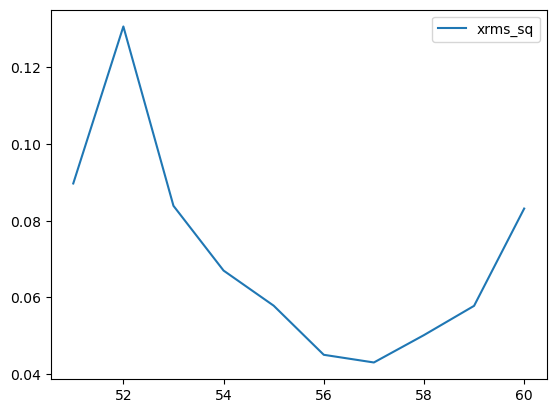

In [32]:
optimizer.data.iloc[-10:].plot(y='xrms_sq')

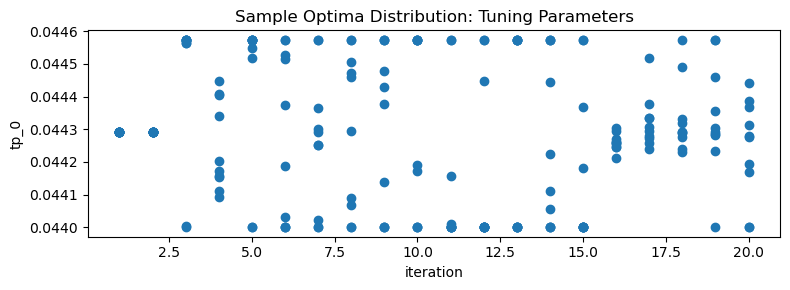

In [25]:
from emitopt.plot_utils import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(results, show_valid_only=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


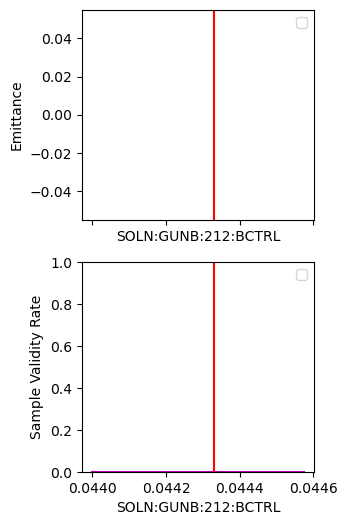

In [26]:
from plot_utils_fix import plot_virtual_emittance_vs_tuning
fig, axs = plot_virtual_emittance_vs_tuning(optimizer, torch.tensor([[0.04433]]))

(<Figure size 600x1000 with 5 Axes>,
 array([<Axes: ylabel='bb_penalty'>,
        <Axes: ylabel='log10_total_intensity'>, <Axes: ylabel='xrms_sq'>,
        <Axes: ylabel='yrms_sq'>,
        <Axes: xlabel='QUAD:HTR:120:BCTRL', ylabel='$\\alpha\\,$[bb_penalty]'>],
       dtype=object))

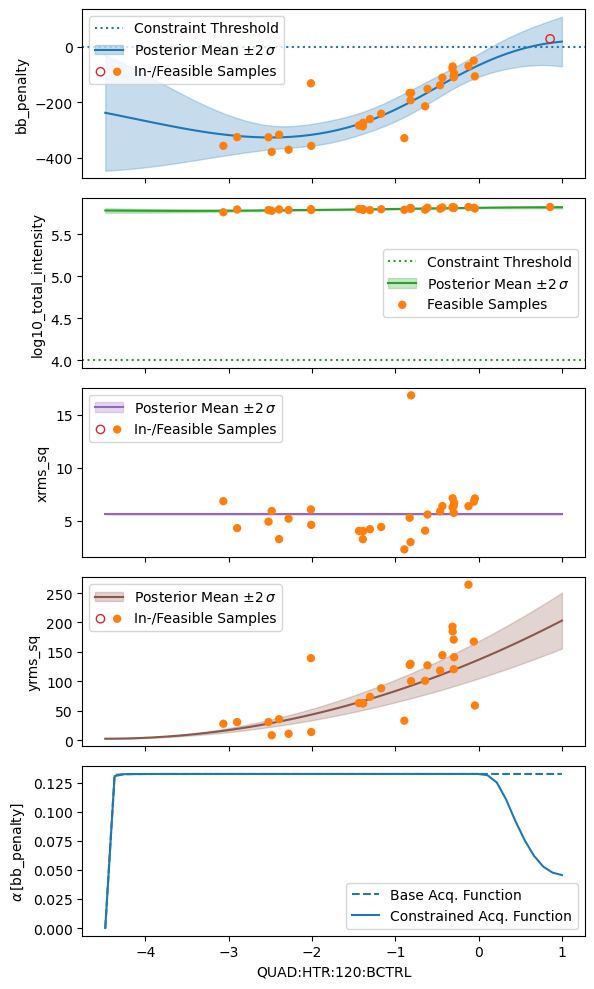

In [27]:
from xopt.generators.bayesian.visualize import visualize_generator_model
visualize_generator_model(optimizer.generator, 
                          variable_names=['QUAD:HTR:120:BCTRL'])


(<Figure size 600x1000 with 5 Axes>,
 array([<Axes: ylabel='bb_penalty'>,
        <Axes: ylabel='log10_total_intensity'>, <Axes: ylabel='xrms_sq'>,
        <Axes: ylabel='yrms_sq'>,
        <Axes: xlabel='QUAD:HTR:120:BCTRL', ylabel='$\\alpha\\,$[bb_penalty]'>],
       dtype=object))

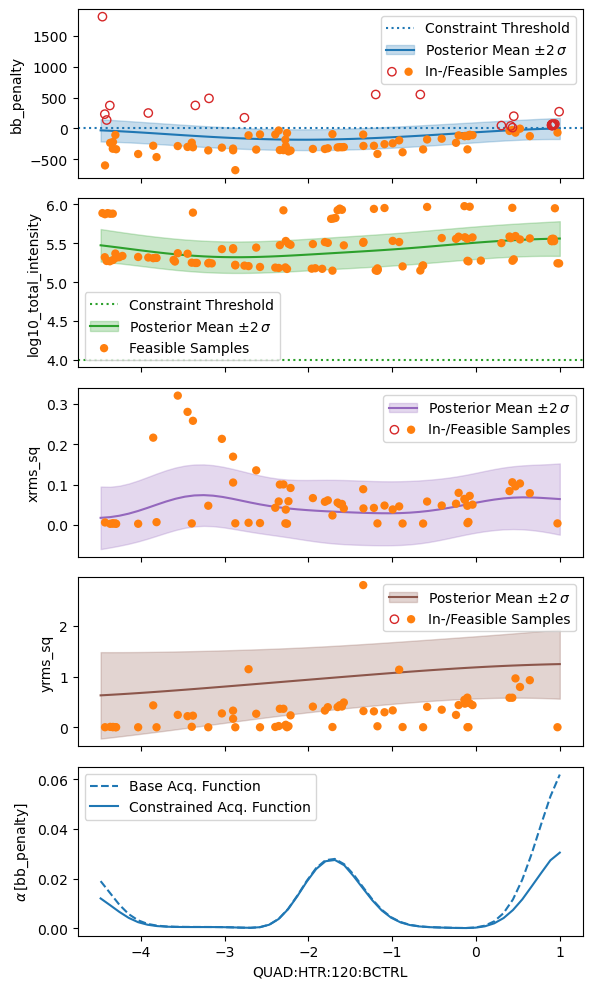

In [32]:
visualize_generator_model(optimizer.generator, variable_names=['QUAD:HTR:120:BCTRL'], 
                          reference_point={'SOLN:GUNB:212:BCTRL':0.04437})

<Axes: >

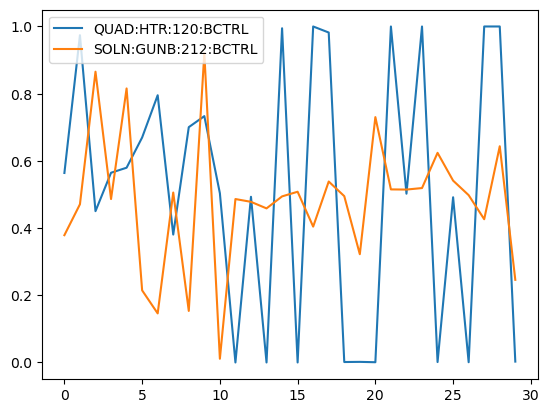

In [33]:
# you can also normalize the variables
optimizer.vocs.normalize_inputs(optimizer.data).plot(y=optimizer.vocs.variable_names)

In [ ]:
optimizer.dump_file = 'BAX_run1.yml'

In [30]:
data2 = optimizer.data[optimizer.data['xrms_sq']>0.025 and optimizer.data['yrms_sq']> ]


In [32]:
model = optimizer.generator.train_model(data2)

(<Figure size 600x1000 with 5 Axes>,
 array([<Axes: ylabel='bb_penalty'>,
        <Axes: ylabel='log10_total_intensity'>, <Axes: ylabel='xrms_sq'>,
        <Axes: ylabel='yrms_sq'>,
        <Axes: xlabel='QUAD:HTR:120:BCTRL', ylabel='$\\alpha\\,$[bb_penalty]'>],
       dtype=object))

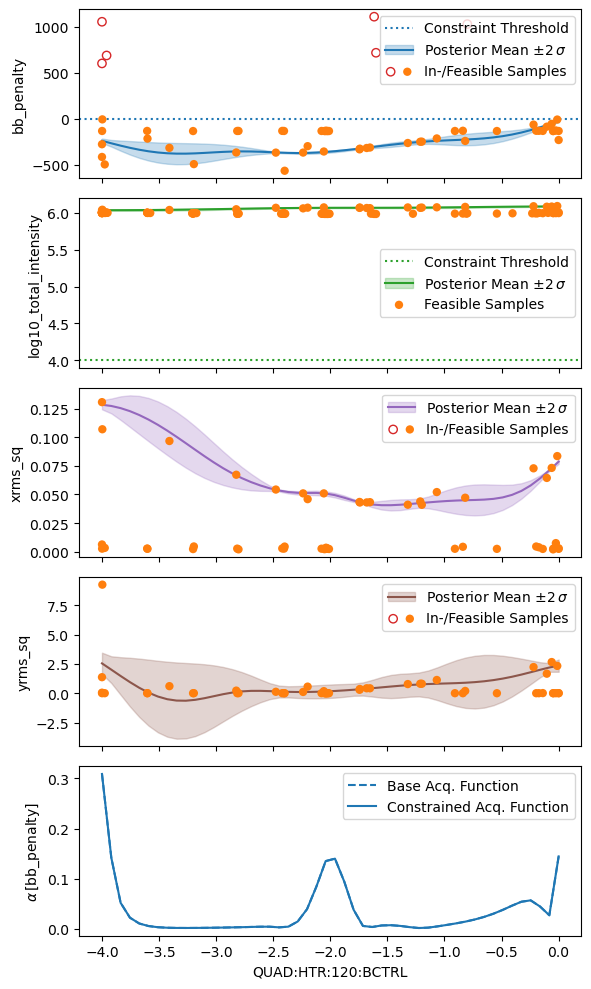

In [33]:
visualize_generator_model(optimizer.generator, variable_names=['QUAD:HTR:120:BCTRL'], 
                          reference_point={'SOLN:GUNB:212:BCTRL':0.0443})

In [28]:
optimizer.generator.data

,QUAD:HTR:120:BCTRL,SOLN:GUNB:212:BCTRL,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,...,ACCL:L0B:0110:ADES,ACCL:L0B:0110:PDES,ACCL:L0B:0130:PDES,time,Sx_mm,Sy_mm,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-1.389252,0.044217,1082.853546,846.116751,192.652895,740.322443,-288.470378,608485.0,5.784250,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.192653,0.740322,0.037115,0.548077,3.434619,False
1,0.857924,0.044270,1124.342833,656.068899,290.997698,1469.905344,-39.384700,657034.0,5.817588,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.290998,1.469905,0.084680,2.160622,3.659250,False
2,-2.012150,0.044497,1107.384840,703.099374,228.402257,1119.419494,-134.092711,614886.0,5.788795,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.228402,1.119419,0.052168,1.253100,3.430241,False
3,-1.385567,0.044279,1084.339683,833.207788,204.734293,817.041821,-271.826782,601612.0,5.779316,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.204734,0.817042,0.041916,0.667557,3.472345,False
4,-1.303616,0.044468,1086.677049,820.427478,207.907378,846.286408,-259.396399,613763.0,5.788001,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.207907,0.846286,0.043225,0.716201,3.438167,False
5,-0.810235,0.044123,1099.855348,747.959019,214.099039,1212.489792,-162.895183,620414.0,5.792682,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.214099,1.212490,0.045838,1.470131,3.429724,False
6,-0.121475,0.044084,1119.544860,648.616516,244.527593,1528.168847,-33.665440,646627.0,5.810654,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.244528,1.528169,0.059794,2.335300,3.411357,False
7,-2.393605,0.044290,1078.969259,860.151007,219.988354,696.403105,-299.049988,601573.0,5.779288,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.219988,0.696403,0.048395,0.484977,3.456338,False
8,-0.642108,0.044088,1094.659761,780.626292,236.159364,960.199000,-213.744202,622142.0,5.793890,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.236159,0.960199,0.055771,0.921982,3.440220,False
9,-0.462213,0.044528,1106.545425,696.116576,786.907966,1154.878688,-64.295029,623429.0,5.794787,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708932e+09,0.786908,1.154879,0.619224,1.333745,3.440135,False


In [30]:
optimizer.evaluate_data({'SOLN:GUNB:212:BCTRL':[0.04425]*10,
                         'QUAD:HTR:120:BCTRL': torch.linspace(-4, 0, 10)})


SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -4.0
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -3.555555582046509
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -3.1111111640930176
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -2.6666667461395264
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -2.222222328186035
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -1.7777777910232544
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -1.3333333730697632
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -0.8888888955116272
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL -0.4444444477558136
fitting image
SOLN:GUNB:212:BCTRL 0.04425
QUAD:HTR:120:BCTRL 0.0
fitting image


,SOLN:GUNB:212:BCTRL,QUAD:HTR:120:BCTRL,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,...,ACCL:L0B:0110:ADES,ACCL:L0B:0110:PDES,ACCL:L0B:0130:PDES,time,Sx_mm,Sy_mm,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,0.04425,-4.000000,1111.378664,685.014949,241.440813,1351.002704,-89.288415,653196.0,5.815044,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.414408,13.510027,5.829367,182.520831,3.520156,False
1,0.04425,-3.555556,1040.874658,1054.709355,262.057878,508.303564,-354.206032,584418.0,5.766724,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.620579,5.083036,6.867433,25.837251,3.452299,False
2,0.04425,-3.111111,1035.808830,1059.666361,264.623673,494.699056,-357.200860,566687.0,5.753343,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.646237,4.946991,7.002569,24.472716,3.454420,False
3,0.04425,-2.666667,1050.658293,1007.042223,240.903558,390.443344,-370.950897,603787.0,5.780884,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.409036,3.904433,5.803452,15.244600,3.476001,False
4,0.04425,-2.222222,1059.617883,953.141658,231.274456,280.064865,-370.926102,613267.0,5.787650,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.312745,2.800649,5.348787,7.843633,3.501832,False
5,0.04425,-1.777778,1072.723920,898.174087,206.698129,495.111401,-337.332840,624935.0,5.795835,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.066981,4.951114,4.272412,24.513530,3.507009,False
6,0.04425,-1.333333,1084.533955,837.046675,197.502535,833.554620,-273.316069,619934.0,5.792345,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,1.975025,8.335546,3.900725,69.481330,3.436251,False
7,0.04425,-0.888889,1097.199756,769.327726,214.536122,1054.706760,-196.989478,648597.0,5.811975,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.145361,10.547068,4.602575,111.240635,3.448906,False
8,0.04425,-0.444444,1110.178612,695.404949,222.953879,1336.413984,-101.621959,650568.0,5.813293,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.229539,13.364140,4.970843,178.600234,3.463031,False
9,0.04425,0.000000,1122.243759,646.676419,255.842587,1603.757347,-19.993549,665333.0,5.823039,/home/physics/ml_tuning/20240225_LCLS_II_Injec...,...,6.5,-20.0,0.0,1.708934e+09,2.558426,16.037573,6.545543,257.203763,3.514667,False


<Axes: >

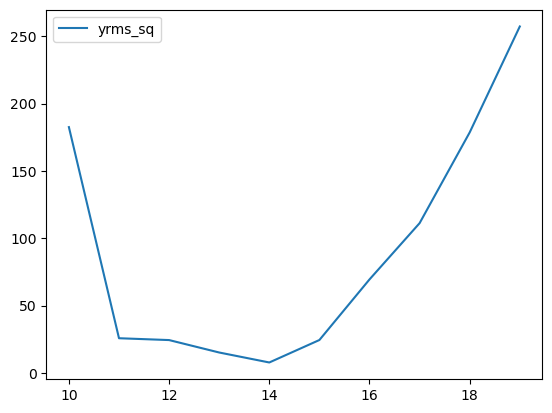

In [35]:
optimizer.data.iloc[-10:].plot(y=['yrms_sq'])

<Axes: >

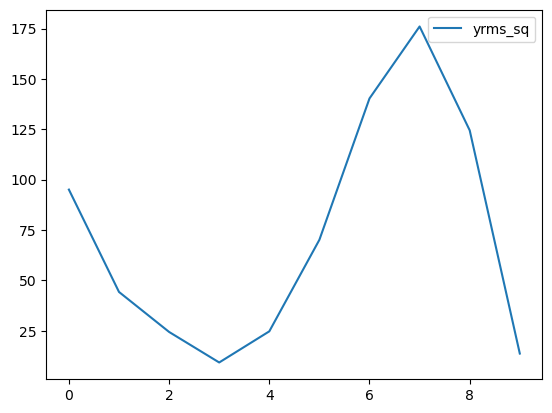

In [36]:
optimizer.data.iloc[:10].plot(y=['yrms_sq'])